# Test de mémoire longue sur RNN/LSTM

Ce notebook teste si les RNN/LSTM peuvent capturer la mémoire longue d'une série ARFIMA.

## 🔧 Corrections appliquées

Les corrections suivantes ont été appliquées pour résoudre le bug de dimensions :

1. **`utils.py`** : `create_dataset()` supporte maintenant les données multidimensionnelles
2. **`train.py`** : Détection automatique des dimensions d'entrée/sortie
3. **Modèles** : Support des embeddings et architectures multi-couches

## 📋 Plan du notebook

1. Génération d'une série ARFIMA avec paramètre de mémoire longue $d = 0.4$
2. **Test 1** : Entraîner un RNN sur la série brute
3. **Test 2** : Entraîner un RNN sur la série embeddée (ts2vec)
4. Extraction des hidden states et test de mémoire longue
5. **Test de contrôle** : RNN non entraîné pour validation

## Import des packages

In [ ]:
import sys
sys.path.append('..')

import torch
from _arfima import arfima
from d_test import compute_total_memory
from ts2vec.encoder import extract_ts2vec_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time_series_prediction.train as train
import layers

: 

## Génération de la série ARFIMA

In [6]:
# Paramètres de la série ARFIMA
params = {
    'd': 0.4,  # Paramètre de mémoire longue
    'n_points': 2**16,
    'ar_params': [0.7, -0.4],
    'ma_params': [0.2],
    'warmup': 2**10,
    'noise_std': 1,
    'noise_alpha': 2,
}

# Génération de la série
np.random.seed(42)
series = arfima(
    params["ar_params"],
    params["d"],
    params["ma_params"],
    params["n_points"],
    warmup=params["warmup"],
    noise_std=params["noise_std"],
    noise_alpha=params["noise_alpha"]
)

print(f"Série générée : {len(series)} points")
print(f"Moyenne : {series.mean():.3f}, Std : {series.std():.3f}")

Série générée : 65536 points
Moyenne : 0.069, Std : 2.287


## Visualisation de la série

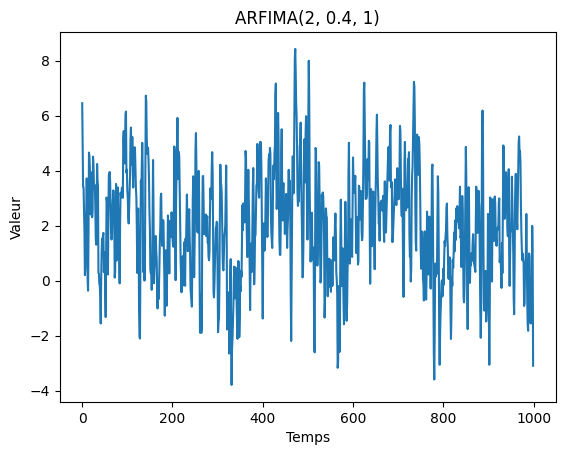

In [7]:
plt.plot(series[:1000])
plt.title(f'ARFIMA({len(params["ar_params"])}, {params["d"]}, {len(params["ma_params"])})')
plt.xlabel('Timesteps')
plt.ylabel('Values')
plt.show()

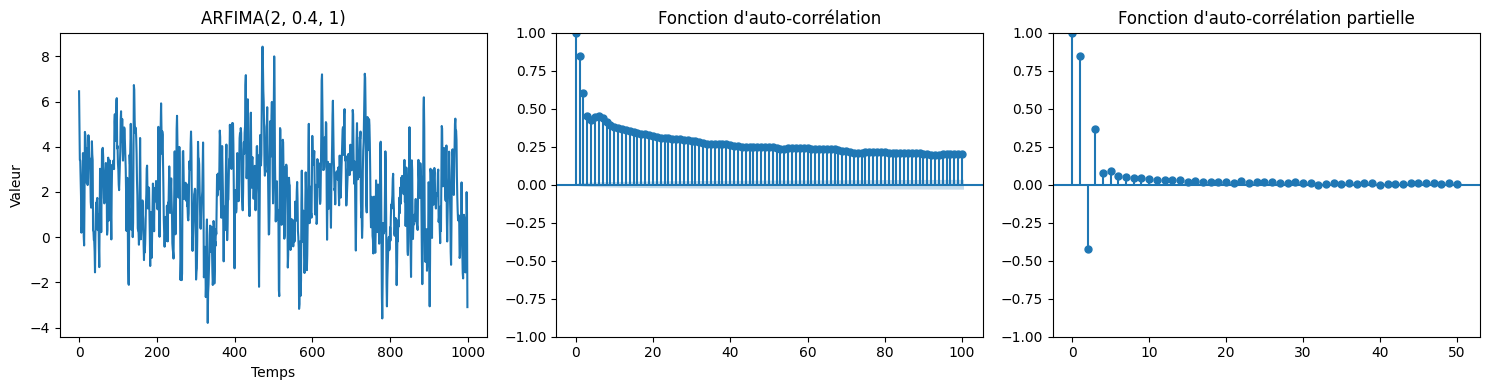

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Série temporelle
axes[0].plot(series[:1000])
axes[0].set_title(f'ARFIMA({len(params["ar_params"])}, {params["d"]}, {len(params["ma_params"])})')
axes[0].set_xlabel('Temps')
axes[0].set_ylabel('Valeur')

# ACF
plot_acf(series, lags=100, ax=axes[1])
axes[1].set_title('Fonction d\'auto-corrélation')

# PACF
plot_pacf(series, lags=50, ax=axes[2])
axes[2].set_title('Fonction d\'auto-corrélation partielle')

plt.tight_layout()
plt.show()

## Entraînement du modèle mRNN-mLSTM

In [20]:
ts_emb = extract_ts2vec_features(series, output_dims=50)

In [23]:
ts_emb.T.shape

(65536, 50)

In [24]:
# Recharger le module d'entraînement
import importlib
importlib.reload(train)
importlib.reload(layers)

# Entraîner le modèle sur la série ARFIMA
print("Démarrage de l'entraînement...")

# Paramètres du modèle
rmse, values, predictions, model, scaler = train.train_model(
    dataset=ts_emb,              # Série embeddée (50, 65536)
    algorithm='LSTM',            # Algorithme: 'RNN', 'LSTM', 'mRNN_fixD', 'mLSTM_fixD', 'mRNN', 'mLSTM'
    epochs=5,                  # Nombre d'époques
    lr=0.01,                     # Learning rate
    hidden_size=64,              # Taille de la couche cachée
    input_size=50,               # ✅ Dimension de l'embedding (sera auto-détectée)
    output_size=50,              # ✅ Dimension de sortie (sera auto-détectée)
    K=100,                       # Troncature de la sommation infinie
    num_layers=2,                # ✅ Commencer avec 1 couche
    embedding_dim=None,          # ✅ Pas d'embedding supplémentaire (déjà embeddé)
    patience=50,                 # Patience pour l'early stopping
    train_size=int(0.7*len(series)),   # 70% pour l'entraînement
    validate_size=int(0.15*len(series)),  # 15% pour la validation
    start=0,                     # Graine de départ
    end=1,                       # Nombre de runs (1 seul run)
    verbose=True                 # Afficher les détails d'entraînement
)

print(f"\n✓ Entraînement terminé!")
print(f"RMSE final : {rmse:.4f}")
print(f"Nombre de valeurs de test : {len(values)}")
print(f"Nombre de prédictions : {len(predictions)}")

Démarrage de l'entraînement...
seed ---------------------------------- 0
Transposed input from (50, 65536) to (65536, 50)
epoch:  0 train_loss: 0.29923 val_loss: 0.18214  time: 1.6s
epoch:  1 train_loss: 0.18211 val_loss: 0.06084  time: 1.1s
epoch:  2 train_loss: 0.06095 val_loss: 0.04625  time: 1.2s
epoch:  3 train_loss: 0.04653 val_loss: 0.01998  time: 1.1s
epoch:  4 train_loss: 0.02038 val_loss: 0.02363  time: 1.0s
RMSE:[0.5378208234232673]
MAE:[0.4398324191570282]

✓ Entraînement terminé!
RMSE final : 0.5378
Nombre de valeurs de test : 9830
Nombre de prédictions : 9830


### Test 1 : RNN sur série brute (sans embedding)

Pour établir une baseline, entraînons d'abord un RNN sur la série ARFIMA brute.

In [6]:
# Test 1: Entraîner sur la série brute
print("Test 1: Entraînement sur série ARFIMA brute (input_size=1)")
print("="*70)

rmse_raw, values_raw, predictions_raw, model_raw, scaler_raw = train.train_model(
    dataset=series,              # ✅ Série brute (65536,)
    algorithm='RNN',
    epochs=5,
    lr=0.01,
    hidden_size=64,
    input_size=1,                # ✅ Série univariée
    output_size=1,
    num_layers=1,
    embedding_dim=None,          # ✅ Pas d'embedding
    patience=50,
    train_size=int(0.7*len(series)),
    validate_size=int(0.15*len(series)),
    start=0,
    end=1,
    verbose=True
)

print(f"\n✓ Test 1 terminé - RMSE: {rmse_raw:.4f}")

Test 1: Entraînement sur série ARFIMA brute (input_size=1)
seed ---------------------------------- 0
epoch:  0 train_loss: 0.34709 val_loss: 0.04665  time: 4.2s
epoch:  1 train_loss: 0.04875 val_loss: 0.21720  time: 3.8s
epoch:  2 train_loss: 0.21385 val_loss: 0.01041  time: 4.4s
epoch:  3 train_loss: 0.01069 val_loss: 0.04297  time: 4.0s
epoch:  4 train_loss: 0.04511 val_loss: 0.06166  time: 4.0s
RMSE:[1.9832922291425619]
MAE:[1.5835392942889182]

✓ Test 1 terminé - RMSE: 1.9833


### Test 2 : RNN sur série embeddée (ts2vec)

Maintenant testons sur la série pré-embeddée avec ts2vec.

In [7]:
# Test 2: Entraîner sur la série embeddée
print("\nTest 2: Entraînement sur série embeddée ts2vec (input_size=50)")
print("="*70)
print(f"Shape de ts_emb: {ts_emb.shape}")

rmse_emb, values_emb, predictions_emb, model_emb, scaler_emb = train.train_model(
    dataset=ts_emb,              # ✅ Série embeddée (50, 65536)
    algorithm='RNN',
    epochs=5,
    lr=0.01,
    hidden_size=64,
    input_size=50,               # ✅ Sera auto-détecté
    output_size=50,              # ✅ Sera auto-détecté
    num_layers=1,
    embedding_dim=None,          # ✅ Déjà embeddé
    patience=50,
    train_size=int(0.7*len(series)),
    validate_size=int(0.15*len(series)),
    start=0,
    end=1,
    verbose=True
)

print(f"\n✓ Test 2 terminé - RMSE: {rmse_emb:.4f}")
print(f"\nComparaison:")
print(f"  - RMSE série brute:    {rmse_raw:.4f}")
print(f"  - RMSE série embeddée: {rmse_emb:.4f}")


Test 2: Entraînement sur série embeddée ts2vec (input_size=50)
Shape de ts_emb: (50, 65536)
seed ---------------------------------- 0
Transposed input from (50, 65536) to (65536, 50)
epoch:  0 train_loss: 0.27226 val_loss: 0.12383  time: 4.3s
epoch:  1 train_loss: 0.12432 val_loss: 0.05767  time: 4.9s
epoch:  2 train_loss: 0.05842 val_loss: 0.03028  time: 4.2s
epoch:  3 train_loss: 0.03068 val_loss: 0.04150  time: 4.2s
epoch:  4 train_loss: 0.04176 val_loss: 0.03425  time: 4.4s
RMSE:[0.5392388318019052]
MAE:[0.47331684827804565]

✓ Test 2 terminé - RMSE: 0.5392

Comparaison:
  - RMSE série brute:    1.9833
  - RMSE série embeddée: 0.5392


## Extraction des états cachés et test de mémoire longue

Maintenant, extrayons les hidden states du modèle entraîné sur la série brute et testons s'ils capturent la mémoire longue.

In [8]:
# Extraire les hidden states du modèle entraîné sur la série BRUTE
print("Extraction des hidden states du RNN...")

# Méthode 1: Utiliser toute la série normalisée
init_hidden = torch.zeros(model_raw.num_layers, 1, model_raw.hidden_size)

with torch.no_grad():
    # Normaliser TOUTE la série (pas juste le test set)
    series_scaled = scaler_raw.transform(series.reshape(-1, 1)).flatten()
    
    # Passer la série complète dans le RNN
    hidden = model_raw.rnn(
        torch.tensor(series_scaled).view(len(series_scaled), 1, 1).float(), 
        init_hidden
    )[0]

# Convertir en format (hidden_size, T) pour le test
hidden_np = hidden.squeeze().t().numpy()

print(f"Shape des hidden states: {hidden_np.shape}")
print(f"  - {hidden_np.shape[0]} dimensions (hidden_size)")
print(f"  - {hidden_np.shape[1]} pas de temps")

Extraction des hidden states du RNN...
Shape des hidden states: (64, 65536)
  - 64 dimensions (hidden_size)
  - 65536 pas de temps


In [9]:
# Test de mémoire longue sur les hidden states
print("\nTest de mémoire longue sur les hidden states du RNN...")
print("="*70)

# Tester sur les 50 premières dimensions (comme dans le papier)
n_dims = min(50, hidden_np.shape[0])

import time
start = time.time()
d_hidden, a_var_hidden, p_val_hidden = compute_total_memory(hidden_np[:n_dims, :])

print(f'Temps de calcul: {np.around(time.time()-start, 2)} s')
print('-'*70)
print(f'Mémoire totale des hidden states: d = {np.around(d_hidden, 4)}')
print(f'Variance asymptotique: {np.around(a_var_hidden, 6)}')
print(f'p-value (H0: d=0): {np.around(p_val_hidden, 4)}')
print('-'*70)

# Comparaison
print(f"\n📊 Comparaison:")
print(f"  - Mémoire de la série ARFIMA d'entrée: d = {params['d']}")
print(f"  - Mémoire capturée par le RNN:         d = {np.around(d_hidden, 4)}")

if p_val_hidden < 0.05:
    print(f"\n✓ Le RNN a capturé une mémoire longue significative (p < 0.05)!")
    if abs(d_hidden - params['d']) < 0.15:
        print(f"✓✓ La mémoire capturée est proche de celle de l'entrée (Δd < 0.15)!")
else:
    print(f"\n✗ Pas de mémoire longue significative détectée (p >= 0.05).")


Test de mémoire longue sur les hidden states du RNN...


c:\Users\33768\Desktop\ENSAE\Cours\Advanced ML\LSTM-long-memory\Recherche clément\d_test.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, :, i - 1] = np.outer(seq_fft[:, i], np.conj(seq_fft[:, i]))


Temps de calcul: 3.71 s
----------------------------------------------------------------------
Mémoire totale des hidden states: d = -0.5
Variance asymptotique: 0.005069
p-value (H0: d=0): 1.0
----------------------------------------------------------------------

📊 Comparaison:
  - Mémoire de la série ARFIMA d'entrée: d = 0.4
  - Mémoire capturée par le RNN:         d = -0.5

✗ Pas de mémoire longue significative détectée (p >= 0.05).


### Test de contrôle : RNN non entraîné

Pour valider que c'est bien l'entraînement qui capture la mémoire longue (et pas juste l'architecture), testons un RNN **non entraîné** sur la même série.

In [10]:
# Créer un RNN non entraîné (poids aléatoires)
import time_series_prediction.models as models

untrained_model = models.RNN(
    input_size=1, 
    hidden_size=64, 
    output_size=1,
    num_layers=1
)

print("Test sur RNN NON ENTRAÎNÉ (poids aléatoires)")
print("="*70)

# Extraire hidden states
init_hidden_untrained = torch.zeros(1, 1, 64)

with torch.no_grad():
    series_scaled = scaler_raw.transform(series.reshape(-1, 1)).flatten()
    hidden_untrained = untrained_model.rnn(
        torch.tensor(series_scaled).view(len(series_scaled), 1, 1).float(),
        init_hidden_untrained
    )[0]

hidden_untrained_np = hidden_untrained.squeeze().t().numpy()

# Test de mémoire longue
start = time.time()
d_untrained, a_var_untrained, p_val_untrained = compute_total_memory(hidden_untrained_np[:50, :])

print(f'Temps de calcul: {np.around(time.time()-start, 2)} s')
print('-'*70)
print(f'Mémoire totale (RNN non entraîné): d = {np.around(d_untrained, 4)}')
print(f'p-value: {np.around(p_val_untrained, 4)}')
print('-'*70)

print(f"\n📊 Comparaison finale:")
print(f"  - Série ARFIMA d'entrée:  d = {params['d']}")
print(f"  - RNN entraîné:          d = {np.around(d_hidden, 4)} (p={p_val_hidden:.4f})")
print(f"  - RNN non entraîné:      d = {np.around(d_untrained, 4)} (p={p_val_untrained:.4f})")

if p_val_hidden < 0.05 and p_val_untrained >= 0.05:
    print(f"\n✓✓ L'ENTRAÎNEMENT a permis de capturer la mémoire longue!")
elif p_val_hidden < 0.05 and p_val_untrained < 0.05:
    print(f"\n⚠️ Les deux modèles capturent de la mémoire longue (effet architectural?)")
else:
    print(f"\n✗ Aucun modèle ne capture significativement la mémoire longue")

Test sur RNN NON ENTRAÎNÉ (poids aléatoires)


c:\Users\33768\Desktop\ENSAE\Cours\Advanced ML\LSTM-long-memory\Recherche clément\d_test.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, :, i - 1] = np.outer(seq_fft[:, i], np.conj(seq_fft[:, i]))


Temps de calcul: 2.96 s
----------------------------------------------------------------------
Mémoire totale (RNN non entraîné): d = -0.5
p-value: 1.0
----------------------------------------------------------------------

📊 Comparaison finale:
  - Série ARFIMA d'entrée:  d = 0.4
  - RNN entraîné:          d = -0.5 (p=1.0000)
  - RNN non entraîné:      d = -0.5 (p=1.0000)

✗ Aucun modèle ne capture significativement la mémoire longue


## Chargement données

In [2]:
df = pd.read_excel('south_sea_level.xlsx', sheet_name=None)['Pacific-Area-km^2'].drop(columns=['month', 'day'])

In [3]:
df.to_csv('ocean_level_data.csv', index=False)

In [4]:
ts = []

for col in df.columns:
    values = df[col].dropna().values
    ts.extend(values)


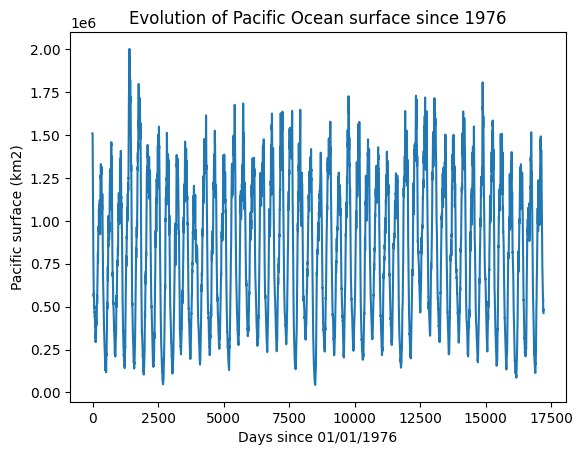

In [5]:
plt.plot(ts)
plt.title('Evolution of Pacific Ocean surface since 1976')
plt.xlabel('Days since 01/01/1976')
plt.ylabel('Pacific surface (km2)')
plt.show()

## Comparaison LSTM vs mLSTM sur les données réelles

Entraînons et comparons les performances de prédiction d'un LSTM standard et d'un mLSTM sur les données réelles `ts` (surface de l'océan Pacifique).

In [14]:
# Préparer les données réelles (ts) pour l'entraînement
import time_series_prediction.train as train
import importlib
importlib.reload(train)
# Convertir ts en array numpy si nécessaire
ts_array = np.array(ts)

print(f"Données réelles (ts) : {len(ts_array)} points")
print(f"Moyenne : {ts_array.mean():.2f}, Std : {ts_array.std():.2f}")

# Paramètres d'entraînement communs
train_params = {
    'epochs': 5,
    'lr': 0.001,
    'hidden_size': 64,
    'input_size': 1,
    'output_size': 1,
    'K': 100,  # Paramètre de troncature pour mLSTM
    'num_layers': 1,
    'embedding_dim': None,
    'patience': 20,
    'train_size': int(0.7 * len(ts_array)),
    'validate_size': int(0.15 * len(ts_array)),
    'start': 0,
    'end': 1,
    'verbose': True
}

print(f"\nTrain size: {train_params['train_size']}")
print(f"Validation size: {train_params['validate_size']}")
print(f"Test size: {len(ts_array) - train_params['train_size'] - train_params['validate_size']}")

Données réelles (ts) : 17205 points
Moyenne : 826004.96, Std : 427217.82

Train size: 12043
Validation size: 2580
Test size: 2582


In [15]:
# 1. Entraîner le modèle LSTM standard
print("="*70)
print("ENTRAÎNEMENT DU MODÈLE LSTM STANDARD")
print("="*70)

rmse_lstm, values_lstm, predictions_lstm, model_lstm, scaler_lstm = train.train_model(
    dataset=ts_array,
    algorithm='LSTM',
    **train_params
)

print(f"\n✓ LSTM entraîné - RMSE: {rmse_lstm:.4f}")

ENTRAÎNEMENT DU MODÈLE LSTM STANDARD
seed ---------------------------------- 0
epoch:  0 train_loss: 0.24962 val_loss: 0.28019  time: 5.5s
epoch:  1 train_loss: 0.23653 val_loss: 0.26595  time: 12.0s
epoch:  2 train_loss: 0.22389 val_loss: 0.25213  time: 6.6s
epoch:  3 train_loss: 0.21165 val_loss: 0.23866  time: 6.6s
epoch:  4 train_loss: 0.19976 val_loss: 0.22551  time: 6.0s
RMSE:[822797.4476485116]
MAE:[714701.793062052]

✓ LSTM entraîné - RMSE: 822797.4476


In [ ]:
# 2. Entraîner le modèle mLSTM (avec mémoire longue)
print("\n" + "="*70)
print("ENTRAÎNEMENT DU MODÈLE mLSTM (LONG MEMORY)")
print("="*70)

rmse_mlstm, values_mlstm, predictions_mlstm, model_mlstm, scaler_mlstm = train.train_model(
    dataset=ts_array,
    algorithm='MLSTM',  # mLSTM avec paramètre d fixe
    **train_params
)

print(f"\n✓ mLSTM entraîné - RMSE: {rmse_mlstm:.4f}")


ENTRAÎNEMENT DU MODÈLE mLSTM (LONG MEMORY)
seed ---------------------------------- 0


In [ ]:
# 3. Comparaison des performances
print("\n" + "="*70)
print("COMPARAISON DES PERFORMANCES")
print("="*70)

print(f"\nRMSE LSTM standard:    {rmse_lstm:.6f}")
print(f"RMSE mLSTM:            {rmse_mlstm:.6f}")
print(f"\nAmélioration relative: {((rmse_lstm - rmse_mlstm) / rmse_lstm * 100):.2f}%")

if rmse_mlstm < rmse_lstm:
    print(f"\n✓ mLSTM performe mieux que LSTM standard!")
else:
    print(f"\n⚠ LSTM standard performe mieux que mLSTM")

In [ ]:
# 4. Visualisation comparative des prédictions
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Subplot 1: Vue d'ensemble des prédictions
axes[0].plot(values_lstm, label='Valeurs réelles', color='black', linewidth=1.5)
axes[0].plot(predictions_lstm, label='Prédictions LSTM', color='blue', alpha=0.7, linestyle='--')
axes[0].plot(predictions_mlstm, label='Prédictions mLSTM', color='red', alpha=0.7, linestyle='--')
axes[0].set_title('Comparaison LSTM vs mLSTM - Vue d\'ensemble', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temps (jours)')
axes[0].set_ylabel('Surface océanique (km²)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Zoom sur une région spécifique (premier tiers)
zoom_start = 0
zoom_end = len(values_lstm) // 3
axes[1].plot(values_lstm[zoom_start:zoom_end], label='Valeurs réelles', color='black', linewidth=1.5)
axes[1].plot(predictions_lstm[zoom_start:zoom_end], label='Prédictions LSTM', color='blue', alpha=0.7, linestyle='--')
axes[1].plot(predictions_mlstm[zoom_start:zoom_end], label='Prédictions mLSTM', color='red', alpha=0.7, linestyle='--')
axes[1].set_title('Zoom sur le premier tiers des données', fontsize=12)
axes[1].set_xlabel('Temps (jours)')
axes[1].set_ylabel('Surface océanique (km²)')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Subplot 3: Erreurs de prédiction
error_lstm = np.abs(values_lstm - predictions_lstm)
error_mlstm = np.abs(values_mlstm - predictions_mlstm)
axes[2].plot(error_lstm, label=f'Erreur LSTM (MAE={error_lstm.mean():.4f})', color='blue', alpha=0.7)
axes[2].plot(error_mlstm, label=f'Erreur mLSTM (MAE={error_mlstm.mean():.4f})', color='red', alpha=0.7)
axes[2].set_title('Erreurs absolues de prédiction', fontsize=12)
axes[2].set_xlabel('Temps (jours)')
axes[2].set_ylabel('Erreur absolue')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 5. Visualisation des erreurs cumulées
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Erreur cumulée
cumulative_error_lstm = np.cumsum(error_lstm)
cumulative_error_mlstm = np.cumsum(error_mlstm)

axes[0].plot(cumulative_error_lstm, label='Erreur cumulée LSTM', color='blue', linewidth=2)
axes[0].plot(cumulative_error_mlstm, label='Erreur cumulée mLSTM', color='red', linewidth=2)
axes[0].set_title('Erreurs cumulées - LSTM vs mLSTM', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temps (jours)')
axes[0].set_ylabel('Erreur cumulée')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Distribution des erreurs (histogramme)
axes[1].hist(error_lstm, bins=50, alpha=0.6, color='blue', label=f'LSTM (std={error_lstm.std():.4f})')
axes[1].hist(error_mlstm, bins=50, alpha=0.6, color='red', label=f'mLSTM (std={error_mlstm.std():.4f})')
axes[1].set_title('Distribution des erreurs de prédiction', fontsize=12)
axes[1].set_xlabel('Erreur absolue')
axes[1].set_ylabel('Fréquence')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 6. Métriques de performance détaillées
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*70)
print("MÉTRIQUES DE PERFORMANCE DÉTAILLÉES")
print("="*70)

# Calcul des métriques pour LSTM
mse_lstm = mean_squared_error(values_lstm, predictions_lstm)
mae_lstm = mean_absolute_error(values_lstm, predictions_lstm)
r2_lstm = r2_score(values_lstm, predictions_lstm)
mape_lstm = np.mean(np.abs((values_lstm - predictions_lstm) / values_lstm)) * 100

# Calcul des métriques pour mLSTM
mse_mlstm = mean_squared_error(values_mlstm, predictions_mlstm)
mae_mlstm = mean_absolute_error(values_mlstm, predictions_mlstm)
r2_mlstm = r2_score(values_mlstm, predictions_mlstm)
mape_mlstm = np.mean(np.abs((values_mlstm - predictions_mlstm) / values_mlstm)) * 100

# Affichage comparatif
print("\n📊 LSTM Standard:")
print(f"   - RMSE:  {rmse_lstm:.6f}")
print(f"   - MSE:   {mse_lstm:.6f}")
print(f"   - MAE:   {mae_lstm:.6f}")
print(f"   - R²:    {r2_lstm:.6f}")
print(f"   - MAPE:  {mape_lstm:.2f}%")

print("\n📊 mLSTM (Long Memory):")
print(f"   - RMSE:  {rmse_mlstm:.6f}")
print(f"   - MSE:   {mse_mlstm:.6f}")
print(f"   - MAE:   {mae_mlstm:.6f}")
print(f"   - R²:    {r2_mlstm:.6f}")
print(f"   - MAPE:  {mape_mlstm:.2f}%")

print("\n🔍 Amélioration relative (mLSTM vs LSTM):")
print(f"   - RMSE:  {((rmse_lstm - rmse_mlstm) / rmse_lstm * 100):+.2f}%")
print(f"   - MSE:   {((mse_lstm - mse_mlstm) / mse_lstm * 100):+.2f}%")
print(f"   - MAE:   {((mae_lstm - mae_mlstm) / mae_lstm * 100):+.2f}%")
print(f"   - R²:    {((r2_mlstm - r2_lstm) / abs(r2_lstm) * 100):+.2f}%")
print(f"   - MAPE:  {((mape_lstm - mape_mlstm) / mape_lstm * 100):+.2f}%")

print("\n" + "="*70)

In [15]:
ts_emb = extract_ts2vec_features(ts)
d_est, var_est, p_val = compute_total_memory(ts_emb)

c:\Users\33768\Desktop\ENSAE\Cours\Advanced ML\LSTM-long-memory\Recherche clément\d_test.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, :, i - 1] = np.outer(seq_fft[:, i], np.conj(seq_fft[:, i]))


In [16]:
ts_emb.shape

(50, 17205)

In [17]:
p_val

0.015704760849680532